In [1]:
# 라이브러리 설치
!pip install gdrive_dataset

In [2]:
from gdrivedataset import loader

file_id = "1IbyL1762M0Lgoq7_qm2RaXfl3ney0e9i"
loader.load_from_google_drive(file_id)

========== files ============

data/dataset



In [3]:
import pandas as pd
import os

In [4]:
DATA_DIR = 'data/dataset'

In [5]:
train = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
test = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))
submission = pd.read_csv(os.path.join(DATA_DIR, 'sample_submission.csv'))

In [6]:
train.head()

,id,document,label
0,1,영상이나 음악이 이쁘다 해도 미화시킨 불륜일뿐,0
1,2,히치콕이 이 영화를 봤다면 분명 박수를 쳤을듯...,1
2,3,괜찮은 음악영화가 또 나왔군요!!! 따뜻한 겨울이 될 것 같아요~,1
3,4,아무래도 20년도지난작품이라 지금보기는너무유치하다,0
4,5,지금까지의 영화들이 그랬듯. 이 영화역시 일본에 대한 미화는 여전하다.,0


In [7]:
test.head()

,id,document
0,1,시간 때우기 좋은 영화 지루함
1,2,훈훈한 정이 느껴지는 영화! 가족끼리 드라마 보듯이 보면 딱~!
2,3,Childhood fantasy
3,4,멋있는 영화입니다. 잊을 수 없는!
4,5,너무 감동적이네요 펑펑 울었습니다


In [8]:
!pip install konlpy

In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
from konlpy.tag import Okt
from collections import Counter
from wordcloud import WordCloud

In [10]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [11]:
def check_missing_col(dataframe):
  missing_col = []
  counted_missing_col = 0
  for i, col in enumerate(dataframe.columns):
    missing_values = sum(dataframe[col].isna())
    is_missing = True if missing_values >= 1 else False
    if is_missing:
      counted_missing_col += 1
      print(f'결측치가 있는 컬럼은: {col}입니다')
      print(f'해당 컬럼에 총 {missing_values}개의 결측치가 존재합니다.')
      missing_col.append([col, dataframe[col].dtype])
  if counted_missing_col == 0:
    print('결측치가 존재하지 않습니다')
  return missing_col

missing_col = check_missing_col(train)

결측치가 존재하지 않습니다


In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        5000 non-null   int64 
 1   document  5000 non-null   object
 2   label     5000 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 117.3+ KB


In [13]:
val_count = train['label'].value_counts()
print('라벨 0인 리뷰 개수: ', val_count[0])
print('라벨 1인 리뷰 개수: ', val_count[1])

라벨 0인 리뷰 개수:  2564
라벨 1인 리뷰 개수:  2436


In [14]:
plt.style.use('ggplot')

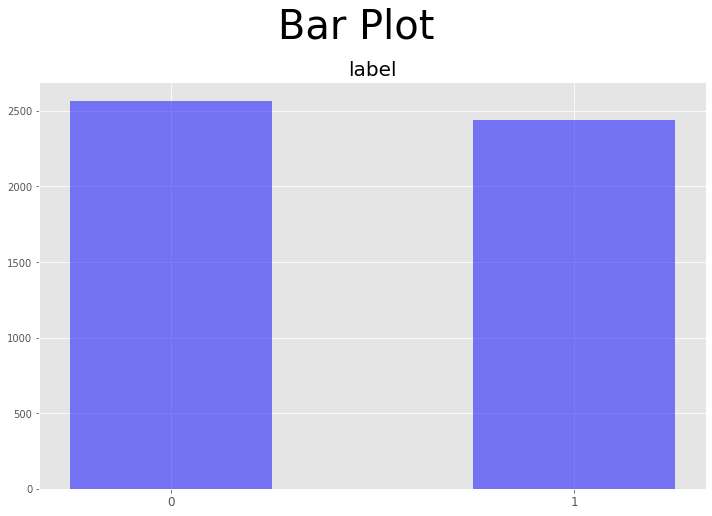

In [15]:
feature = train['label']

plt.figure(figsize=(10, 7.5))
plt.suptitle("Bar Plot", fontsize=40)

plt.title('label', fontsize=20)
temp = feature.value_counts()
plt.bar(temp.keys(), temp.values, width=0.5, color='b', alpha=0.5)
plt.xticks(temp.keys(), fontsize=12)
plt.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.show()

In [16]:
# 리뷰 길이의 평균값 계산
str_len_mean = np.mean(train['document'].str.len())
print('리뷰의 평균 길이: ', str_len_mean)

리뷰의 평균 길이:  27.1352


In [17]:
# 데이터 필터링을 위한 마스크 설정
mask_pos = (train.label == 1)
mask_neg = (train.label == 0)

# 전체/긍정/부정 리뷰 집합 설정
df_train = train.document.copy()
df_pos = train.loc[mask_pos, : ].document
df_neg = train.loc[mask_neg, : ].document

compare = [df_train, df_pos, df_neg]

In [18]:
df_pos.head()

1            히치콕이 이 영화를 봤다면 분명 박수를 쳤을듯...
2    괜찮은 음악영화가 또 나왔군요!!! 따뜻한 겨울이 될 것 같아요~
5       내인생에 있어 손까락에 꼽히는 영화 원작을 능가한 리메이크작
7          마음이 성숙하고 보면 다르게 보이는 영화.. 걸작이다.
8                   가슴 찡했던, 오래 기억에남을 영화!!
Name: document, dtype: object

In [19]:
df_neg.head()

0                  영상이나 음악이 이쁘다 해도 미화시킨 불륜일뿐
3                아무래도 20년도지난작품이라 지금보기는너무유치하다
4    지금까지의 영화들이 그랬듯. 이 영화역시 일본에 대한 미화는 여전하다.
6                성룡영화중 최악 .. 차라리 러시아워가 훨씬 나음
9                   결말 기분나쁘다 공포매니아에게 이따위 결말을
Name: document, dtype: object

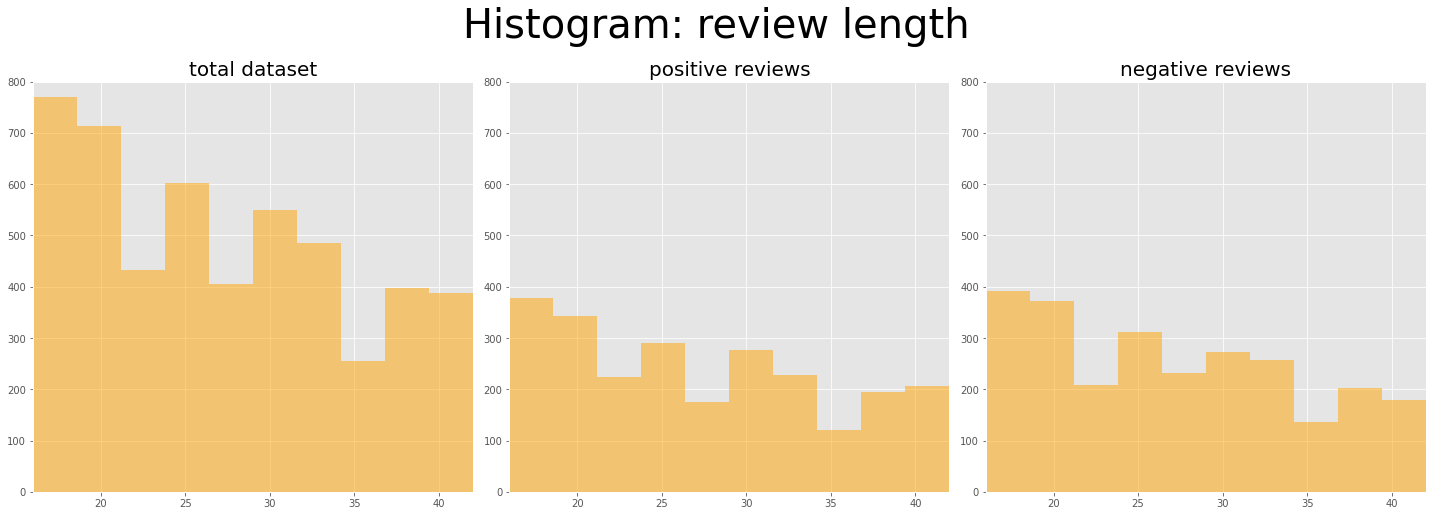

In [20]:
plt.figure(figsize=(20, 7.5))
plt.suptitle("Histogram: review length", fontsize=40)
name = ['total dataset', 'positive reviews', 'negative reviews']

for i in range(len(compare)):
  document = compare[i]
  string_len = [len(x) for x in document]
  plt.subplot(1, 3, i+1)
  plt.title(name[i], fontsize=20)
  plt.axis([16, 42, 0, 800])
  plt.hist(string_len, alpha=0.5, color='orange')

plt.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.show()

In [21]:
word_split = train['document'].str.split()
word_split[:5]

0                     [영상이나, 음악이, 이쁘다, 해도, 미화시킨, 불륜일뿐]
1                 [히치콕이, 이, 영화를, 봤다면, 분명, 박수를, 쳤을듯...]
2       [괜찮은, 음악영화가, 또, 나왔군요!!!, 따뜻한, 겨울이, 될, 것, 같아요~]
3                      [아무래도, 20년도지난작품이라, 지금보기는너무유치하다]
4    [지금까지의, 영화들이, 그랬듯., 이, 영화역시, 일본에, 대한, 미화는, 여전하다.]
Name: document, dtype: object

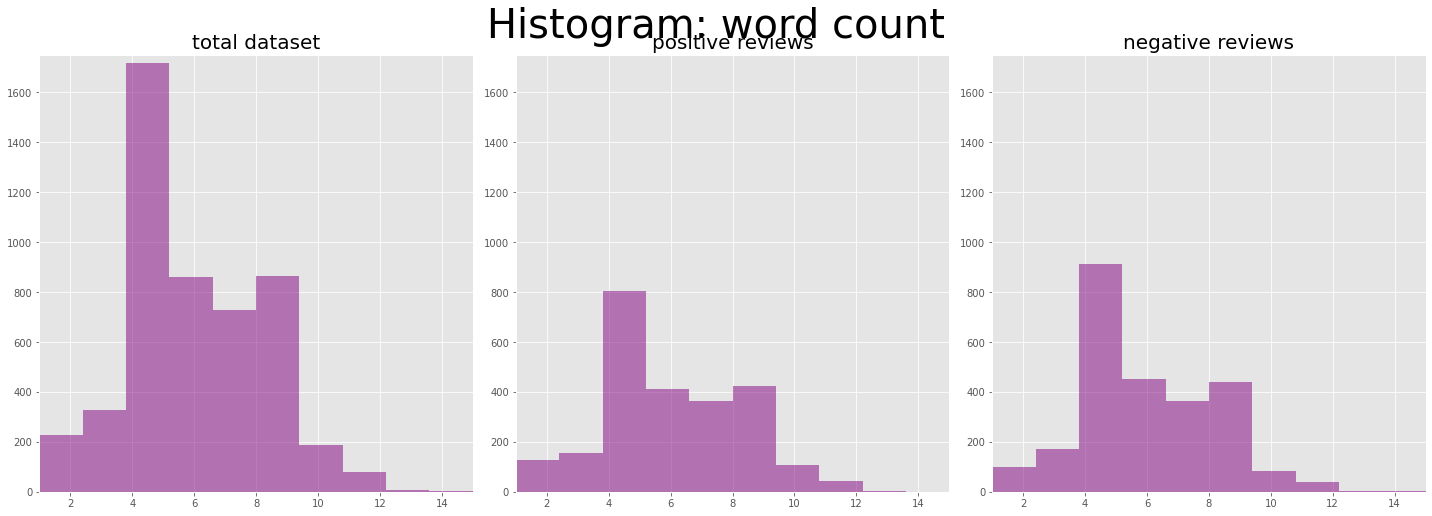

In [22]:
plt.figure(figsize=(20, 7.5))
plt.suptitle("Histogram: word count", fontsize=40)
name = ['total dataset', 'positive reviews', 'negative reviews']

for i in range(len(compare)):
  document = compare[i]
  split = document.str.split()
  split_len = [len(x) for x in split]
  plt.subplot(1, 3, i+1)
  plt.title(name[i], fontsize=20)
  plt.axis([1, 15, 0, 1750])
  plt.hist(split_len, alpha=0.5, color='purple')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [29]:
def df2str(df):
  s = [s for s in df]
  document = ""
  for i in range(len(s)):
    document += s[i]
  return document

def get_noun(text):
  okt = Okt()
  noun = okt.nouns(text)
  for i, v in enumerate(noun):
    if len(v) < 2:
      noun.pop(i)
  count = Counter(noun)
  noun_list = count.most_common(100)

  return noun_list

def visualize(noun_list, title):
  # 워드 클라우드 이미지 생성
  wc = WordCloud(
      font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',    # 한글폰트 경로 설정
      background_color='white',                             # 배경 색깔 정하기
      colormap = 'Dark2',                                # 폰트 색깔 정하기
      width = 800,
      height = 800).generate_from_frequencies(dict(noun_list))
  
  plt.figure(figsize=(10, 10))
  plt.suptitle("Word Cloud", fontsize=40)
  plt.title(title, fontsize=20)
  plt.imshow(wc, interpolation='lanczos')
  plt.axis('off')
  plt.show()

  return wc

In [24]:
document = df2str(df_train)
noun_list = get_noun(document)
noun_list[:5]

[('영화', 1501), ('정말', 320), ('진짜', 269), ('최고', 220), ('평점', 185)]

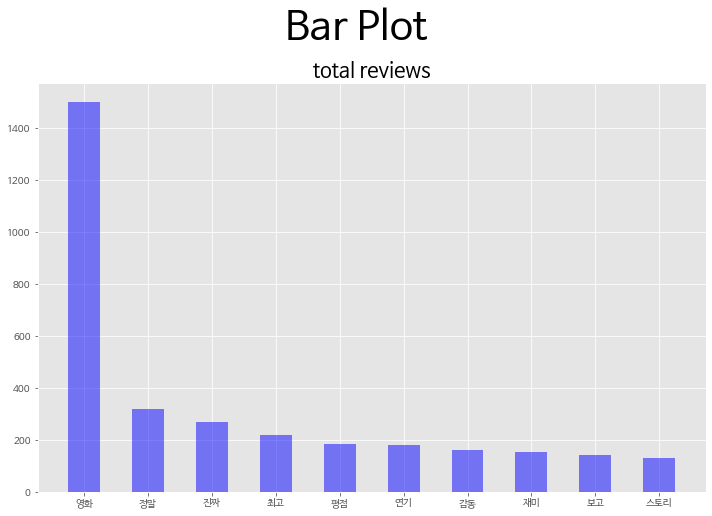

In [25]:
plt.rc('font', family='NanumBarunGothic')
top_10 = dict(noun_list[:10])
plt.figure(figsize=(10, 7.5))
plt.suptitle("Bar Plot", fontsize=40)
plt.title('total reviews', fontsize=20)
plt.bar(top_10.keys(), top_10.values(), width=0.5, color='b', alpha=0.5)
plt.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.show()

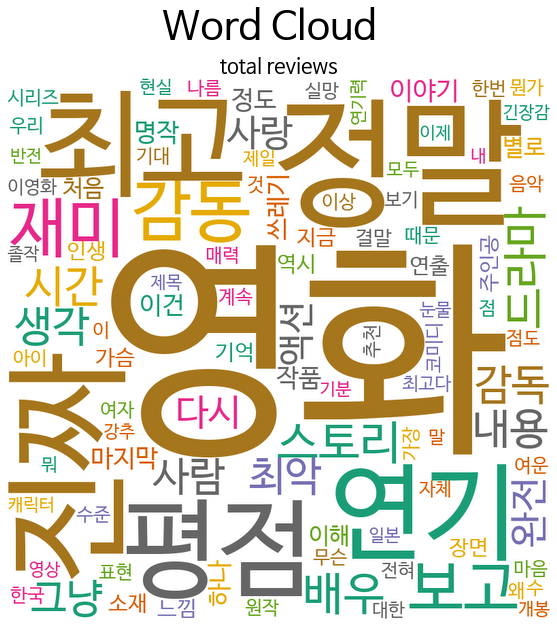

In [31]:
total_reviews = visualize(noun_list,'total reviews') # 워드클라우드 시각화

In [32]:
document_p = df2str(df_pos)
noun_list_p = get_noun(document_p)
noun_list_p[:20]

[('영화', 757),
 ('정말', 216),
 ('최고', 214),
 ('진짜', 136),
 ('감동', 134),
 ('연기', 108),
 ('드라마', 89),
 ('보고', 88),
 ('사랑', 72),
 ('다시', 70),
 ('평점', 67),
 ('생각', 65),
 ('명작', 60),
 ('배우', 58),
 ('사람', 55),
 ('완전', 54),
 ('마지막', 52),
 ('가슴', 51),
 ('이야기', 50),
 ('재미', 48)]

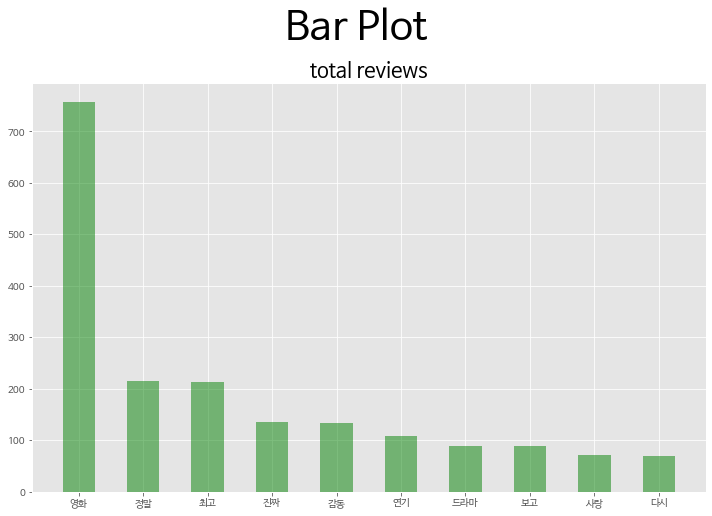

In [33]:
plt.rc('font', family='NanumBarunGothic')
top_10 = dict(noun_list_p[:10])
plt.figure(figsize=(10, 7.5))
plt.suptitle("Bar Plot", fontsize=40)
plt.title('total reviews', fontsize=20)
plt.bar(top_10.keys(), top_10.values(), width=0.5, color='green', alpha=0.5)
plt.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.show()

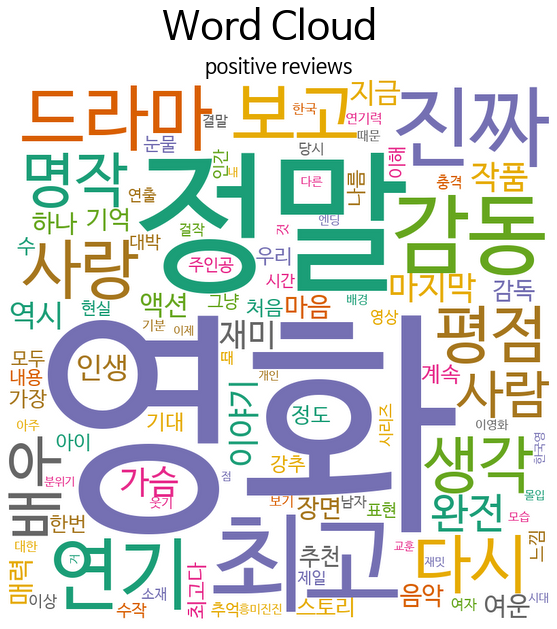

In [34]:
positive_reviews = visualize(noun_list_p, 'positive reviews')

In [35]:
document_n = df2str(df_neg)
noun_list_n = get_noun(document_n)
noun_list_n[:20]

[('영화', 746),
 ('진짜', 132),
 ('평점', 118),
 ('재미', 104),
 ('정말', 104),
 ('스토리', 102),
 ('최악', 98),
 ('시간', 97),
 ('내용', 85),
 ('감독', 78),
 ('그냥', 75),
 ('연기', 72),
 ('쓰레기', 70),
 ('배우', 69),
 ('이건', 55),
 ('별로', 53),
 ('보고', 52),
 ('액션', 43),
 ('하나', 41),
 ('사람', 41)]

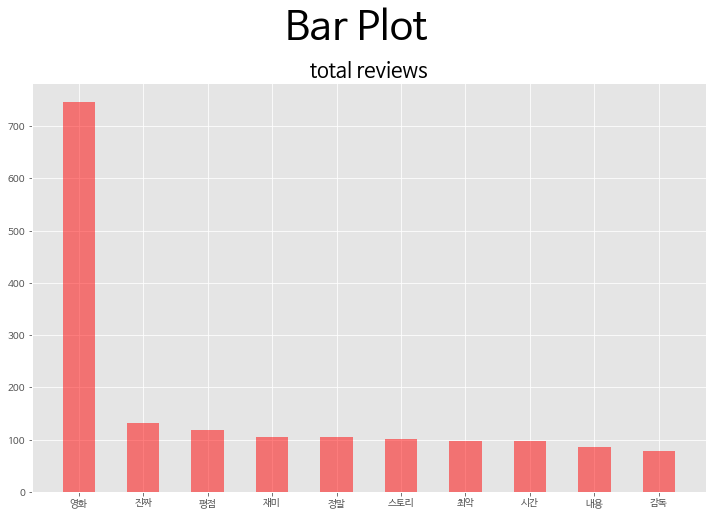

In [36]:
plt.rc('font', family='NanumBarunGothic')
top_10 = dict(noun_list_n[:10])
plt.figure(figsize=(10, 7.5))
plt.suptitle("Bar Plot", fontsize=40)
plt.title('total reviews', fontsize=20)
plt.bar(top_10.keys(), top_10.values(), width=0.5, color='r', alpha=0.5)
plt.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.show()

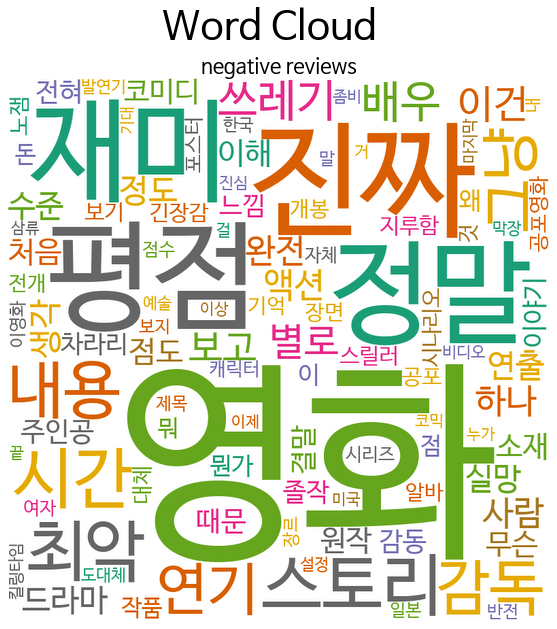

In [37]:
negative_reviews = visualize(noun_list_n, "negative reviews")

In [38]:
# 중복 단어 제거
neg = list(dict(noun_list_n).keys())
pos = list(dict(noun_list_p).keys())

drop_words = [x for x in neg if x in pos]
print("공통으로 등장하는 단어들 TOP 10\n", drop_words[:10])

공통으로 등장하는 단어들 TOP 10
 ['영화', '진짜', '평점', '재미', '정말', '스토리', '시간', '내용', '감독', '그냥']


In [39]:
noun_list_n_fliter = [x for x in noun_list_n if x[0] not in drop_words]
noun_list_p_fliter = [x for x in noun_list_p if x[0] not in drop_words]

In [40]:
print("정제된 부정 리뷰의 상위 단어 TOP 10\n", noun_list_n_fliter[:10])

정제된 부정 리뷰의 상위 단어 TOP 10
 [('최악', 98), ('쓰레기', 70), ('이건', 55), ('별로', 53), ('실망', 36), ('수준', 36), ('점도', 34), ('원작', 31), ('무슨', 31), ('코미디', 29)]


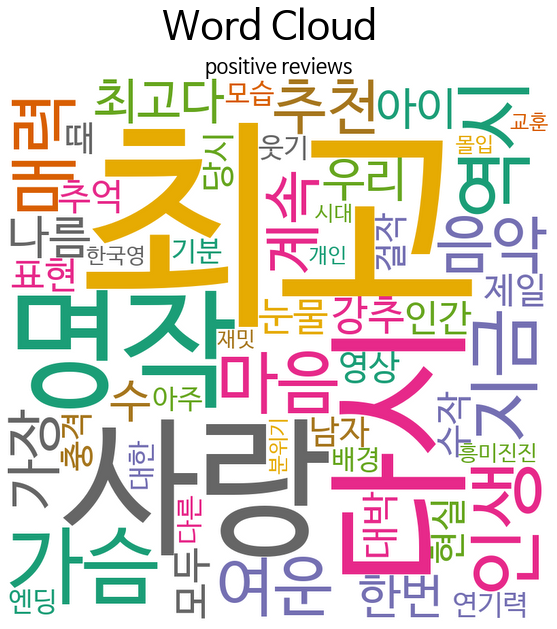

In [41]:
positive_reviews_filtered = visualize(noun_list_p_fliter, "positive reviews")

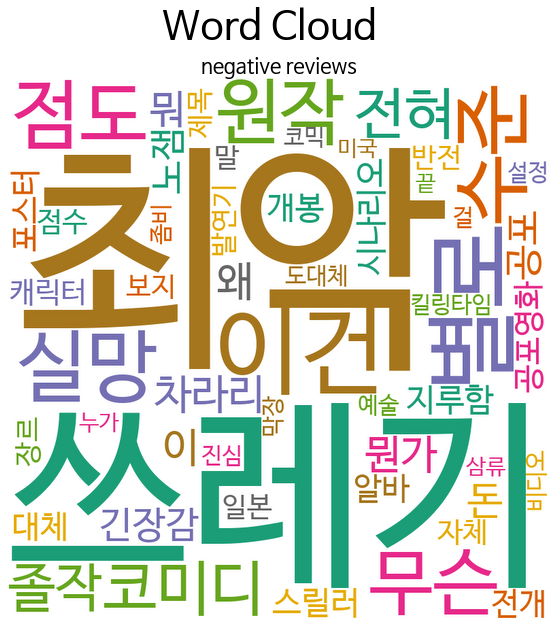

In [42]:
negative_reviews_filtered = visualize(noun_list_n_fliter, "negative reviews")